In [1]:
import numpy as np
import pandas as pd
import healpy as hp
%config InlineBackend.figure_format = 'retina'
from DS_Planck_Unet import west_val, east_val
from matplotlib import pyplot as plt
from DS_Planck_Unet import load_planck_model, draw_pic_with_mask, draw_pic, val_pix
from DS_healpix_fragmentation import *
from DS_data_transformation import pic2fits, normalize
from DS_detector import *
import os
from astropy.coordinates import SkyCoord
from astropy import units as u
from tqdm.notebook import tqdm
from DS_data_transformation import normalize
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
from scipy.special import logit
from DS_models_stat import stat_orig_cats
from DS_detector import rematch_cat
from matplotlib import cm
from matplotlib.ticker import LinearLocator


In [30]:
all_model = load_planck_model('/home/rt2122/Models/pz_only_rot/pz_only_rot.ep0028-vl0.005815-l0.004588.hdf5')

In [14]:
true_clusters = pd.concat([pd.read_csv('/home/rt2122/Data/clusters/planck_z.csv'), 
                           pd.read_csv('/home/rt2122/Data/clusters/acts/all_found.csv')])
true_clusters['pix2'] = radec2pix(true_clusters['RA'], true_clusters['DEC'], 2)
found_clusters = pd.read_csv('/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv')
found_clusters['pix2'] = radec2pix(found_clusters['RA'], found_clusters['DEC'], 2)

In [15]:
df = pd.DataFrame([
    {'RA' : 176.1500, 'DEC' : 19.7589, 'name' : 'Leo'},
    {'RA' : 194.9542, 'DEC': 27.9806, 'name' : 'Coma'},
    {'RA' : 44.2583, 'DEC' : 13.0049, 'name' : 'A399-A401'},
    {'RA' : 201.9792, 'DEC' : -31.2333, 'name' : 'Shapley'}, 
    {'RA' : 150.507, 'DEC' : +2.31204, 'name' : 'G237.0+42.5'}
])
df['pix2'] = radec2pix(df['RA'], df['DEC'], 2)
df['pix'] = radec2pix(df['RA'], df['DEC'], 2**11)
df

,RA,DEC,name,pix2,pix
0,176.1500,19.75890,Leo,11,12344968
1,194.9542,27.98060,Coma,3,4191272
2,44.2583,13.00490,A399-A401,37,39244338
3,201.9792,-31.23330,Shapley,12,13529997
4,150.5070,2.31204,G237.0+42.5,9,10158405


In [ ]:
for pix2 in tqdm(df['pix2']):
    all_data_dict = gen_pics_for_detection(pix2, all_model, step=4, only=True, data_type=np.float)
    all_connected = connect_masks(all_data_dict['ans'], all_data_dict['pic_idx'], data_type=np.float16)
    np.save('/home/rt2122/Data/cur/favourite_clusters/pz_rot/{pix2}.npy'.format(pix2=pix2), all_connected)
    del all_data_dict

In [19]:
def pic9(i, size=32, marker_size=100, add_markers=True, picshape=np.array([5, 5]), rad_check=30/60): 
    
    def cut_in_rad(df, center, radius):
        cen_sc = SkyCoord(ra=center[0]*u.degree, dec=center[1]*u.degree, frame='icrs')
        sc = SkyCoord(ra=df['RA']*u.degree, dec=df['DEC']*u.degree, frame='icrs')
        df = df[sc.separation(cen_sc).degree <= radius]
        df.index = np.arange(len(df))
    
    line = df.iloc[i]
    pix2 = line['pix2']
    
    cur_true = true_clusters.copy()
    cur_true = cur_true[cur_true['pix2'] == pix2] 
    cur_true.index = np.arange(len(cur_true))
    cur_found = found_clusters.copy()
    cur_found = cur_found[cur_found['pix2'] == pix2] 
    cur_found.index = np.arange(len(cur_found))
    
    matr = one_pixel_fragmentation(2, pix2, 10)
    mdict = matr2dict(matr)
    all_connected = np.load('/home/rt2122/Data/cur/favourite_clusters/{pix2}.npy'.format(pix2=pix2))
    coords = np.stack([cur_true['RA'], cur_true['DEC']]).T
    pic, mask = draw_pic_with_mask(None, coords, matr=matr)
    ypic = draw_pic(matr, y=True)
    cm1 = sns.light_palette("red", as_cmap=True)
    cm2 = sns.light_palette("gray", as_cmap=True)
    
    print(line)
    x_cl, y_cl = mdict[line['pix']]
    sm_pic = pic[x_cl-size:x_cl+size, y_cl-size:y_cl+size]
    sm_ypic = ypic[x_cl-size:x_cl+size, y_cl-size:y_cl+size]
    sm_mask = mask[x_cl-size:x_cl+size, y_cl-size:y_cl+size]
    sm_matr = matr[x_cl-size:x_cl+size, y_cl-size:y_cl+size]
    sm_mdict = matr2dict(sm_matr)
    sm_all = all_connected[x_cl-size:x_cl+size, y_cl-size:y_cl+size]
    
    def calc_coords(this_df):
        this_df['x'] = -1
        this_df['y'] = -1
        this_df['pix'] = radec2pix(this_df['RA'], this_df['DEC'], 2**11)
        for i in range(len(this_df)):
            p = this_df.loc[i, 'pix']
            if p in sm_mdict:
                x, y = sm_mdict[p]
                this_df.loc[i, 'x'] = x
                this_df.loc[i, 'y'] = y
        return this_df
    
    cur_true = calc_coords(cur_true)
    cur_found = calc_coords(cur_found)
    
    
    _, ax = plt.subplots(3, 3, figsize=3 * picshape, sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0.1, hspace=0.001)
    
    pic_dict = {6 : logit(sm_all), 7 : sm_ypic, 8:sm_mask}
    
   # val_min = [None, None, None, 0, 3, 6]
    #val_max= [None, None, None, 5, 25, 35]
    val_min=[None]*6
    val_max=[None]*6
    
    for i in range(3):
        for j in range(3):
            if 3*i+j < 6:
                ax[i][j].imshow(sm_pic[:,:,3*i+j], vmin=val_min[3*i+j], vmax=val_max[3*i+j])#, cmap=cmg)
                ax[i][j].set_xlabel(3*i+j)
                #print(3*i+j, sm_pic[:,:,3*i+j].min(), sm_pic[:,:,3*i+j].max())
                #ax[i][j].imshow(sm_mask[:,:,0], alpha=0.5*sm_mask[:,:,0].astype(float), cmap=cm2)
            else:
                ax[i][j].imshow(pic_dict[3*i+j][:,:,0])#, cmap=cmg)
                #ax[i][j].imshow(sm_mask[:,:,0], alpha=0.5*sm_mask[:,:,0].astype(float), cmap=cm2)
    if add_markers:
        for i in range(3):
            for j in range(3):
                s_obj = ax[i][j].scatter(cur_true[cur_true['y'] >= 0]['y'], cur_true[cur_true['y'] >= 0]['x'], marker='x', c='r', 
                                         s=marker_size)
                if i == 2 and j == 2:
                    s_obj.set_label('gt')
                s_obj = ax[i][j].scatter(cur_found[cur_found['y'] >= 0]['y'], cur_found[cur_found['y'] >= 0]['x'], marker='+', c='orange', 
                                         s=marker_size)
                if i == 2 and j == 2:
                    s_obj.set_label('detected')
                    ax[i][j].legend()
            
    ax[2][1].set_xlabel('y map')
    ax[2][0].set_xlabel('Best model prediction')
    ax[2][2].set_xlabel(line['name'])


RA        176.15
DEC      19.7589
name         Leo
pix2          11
pix     12344968
Name: 0, dtype: object


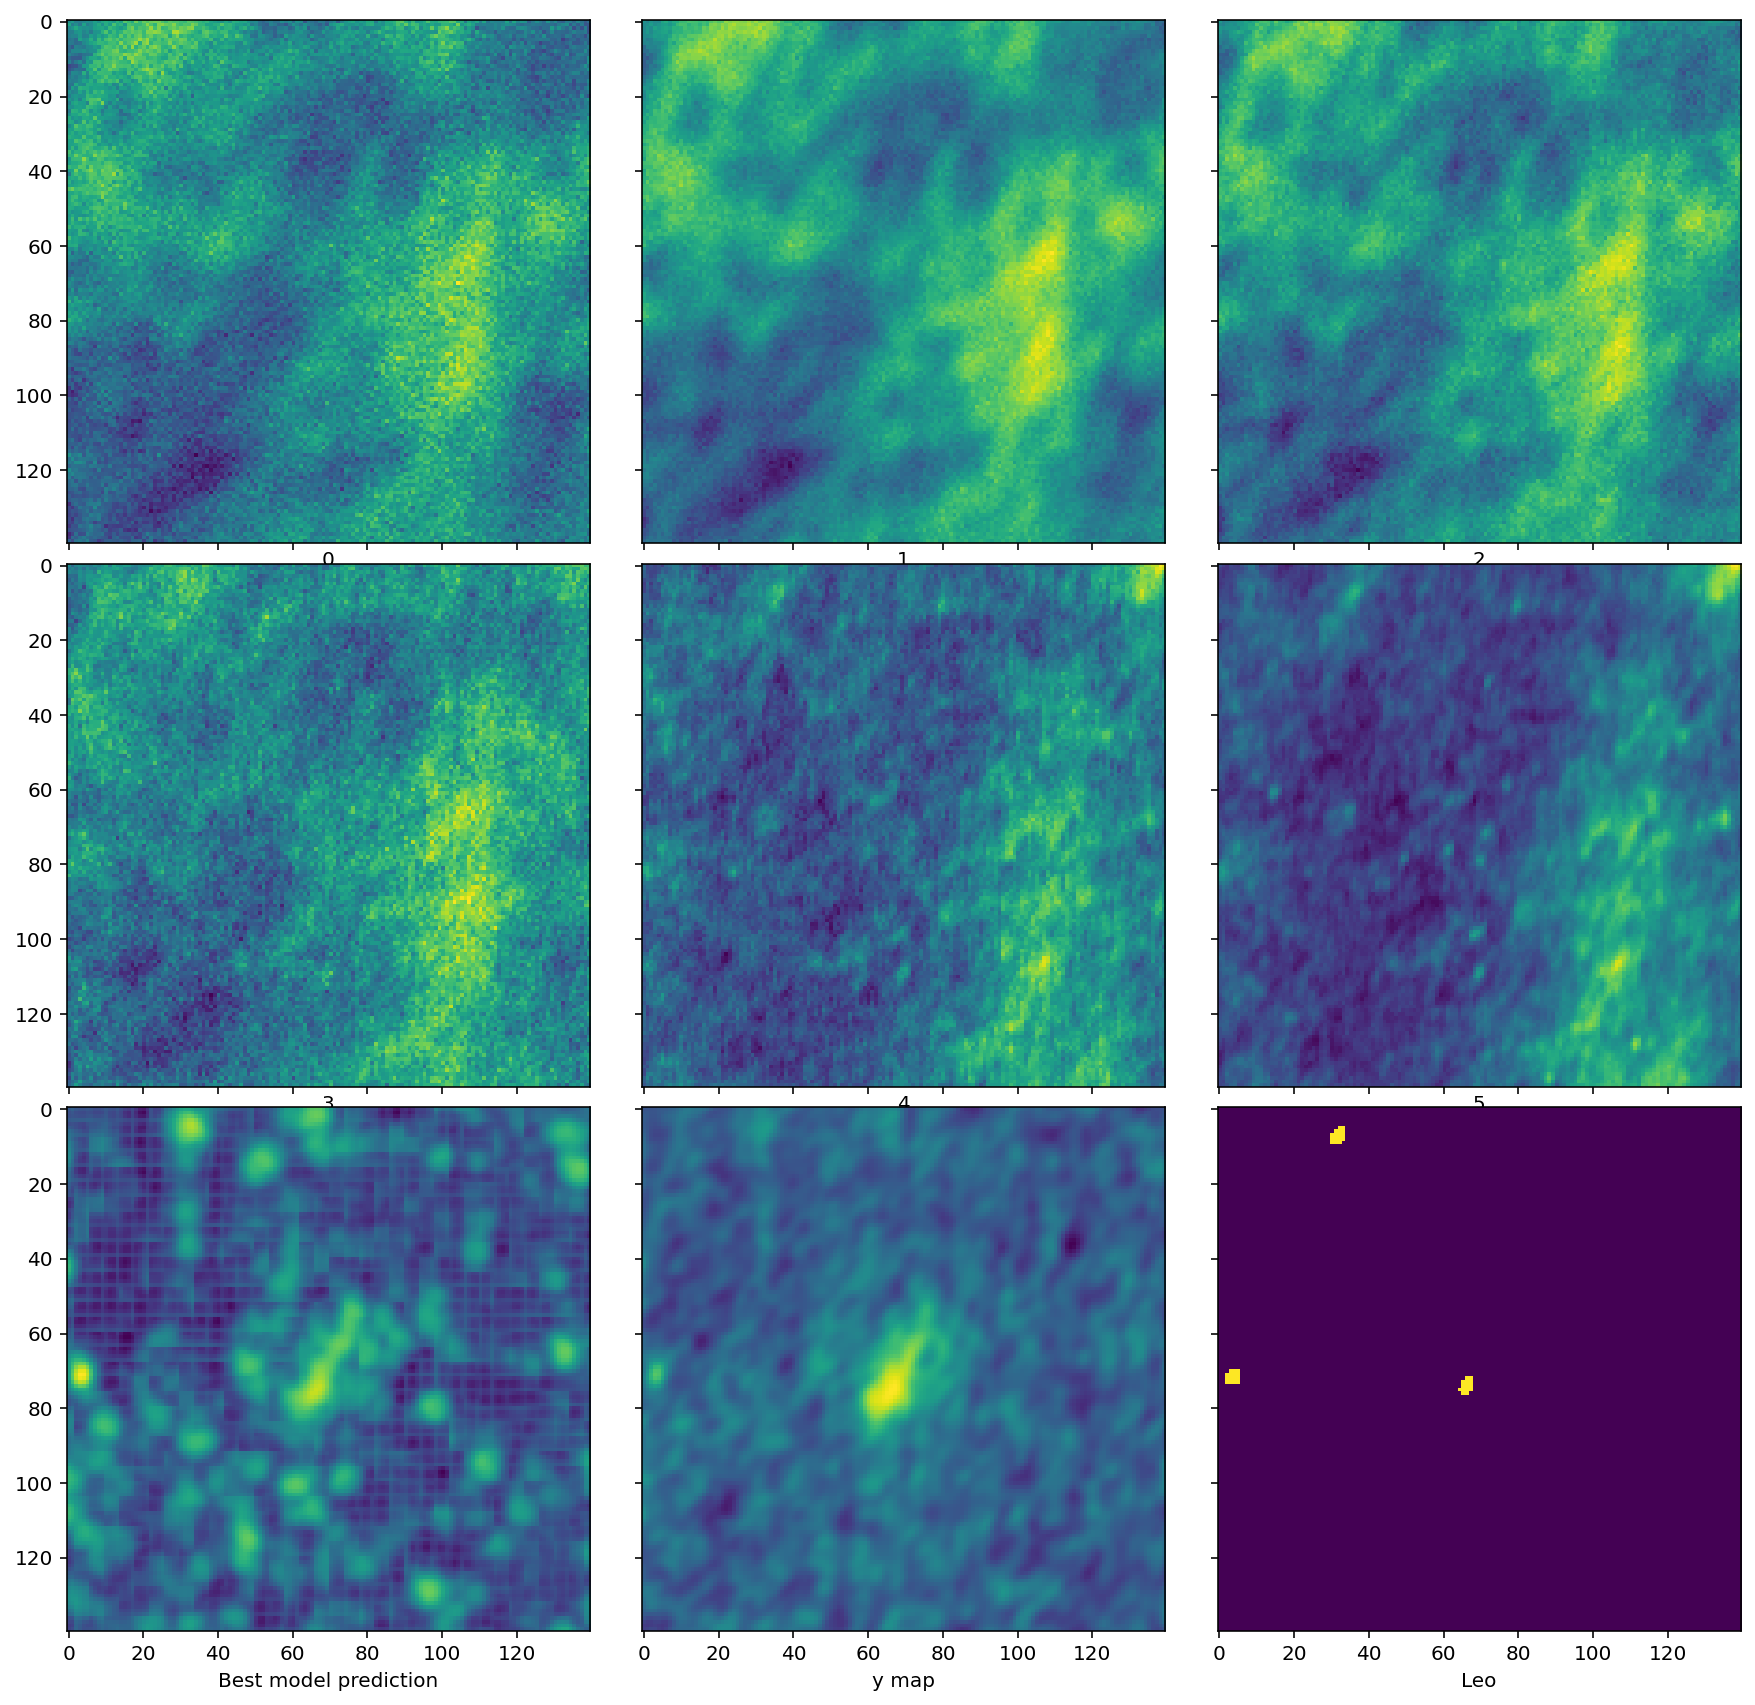

In [28]:
pic9(0, size=70, add_markers=False)

RA      194.954
DEC     27.9806
name       Coma
pix2          3
pix     4191272
Name: 1, dtype: object


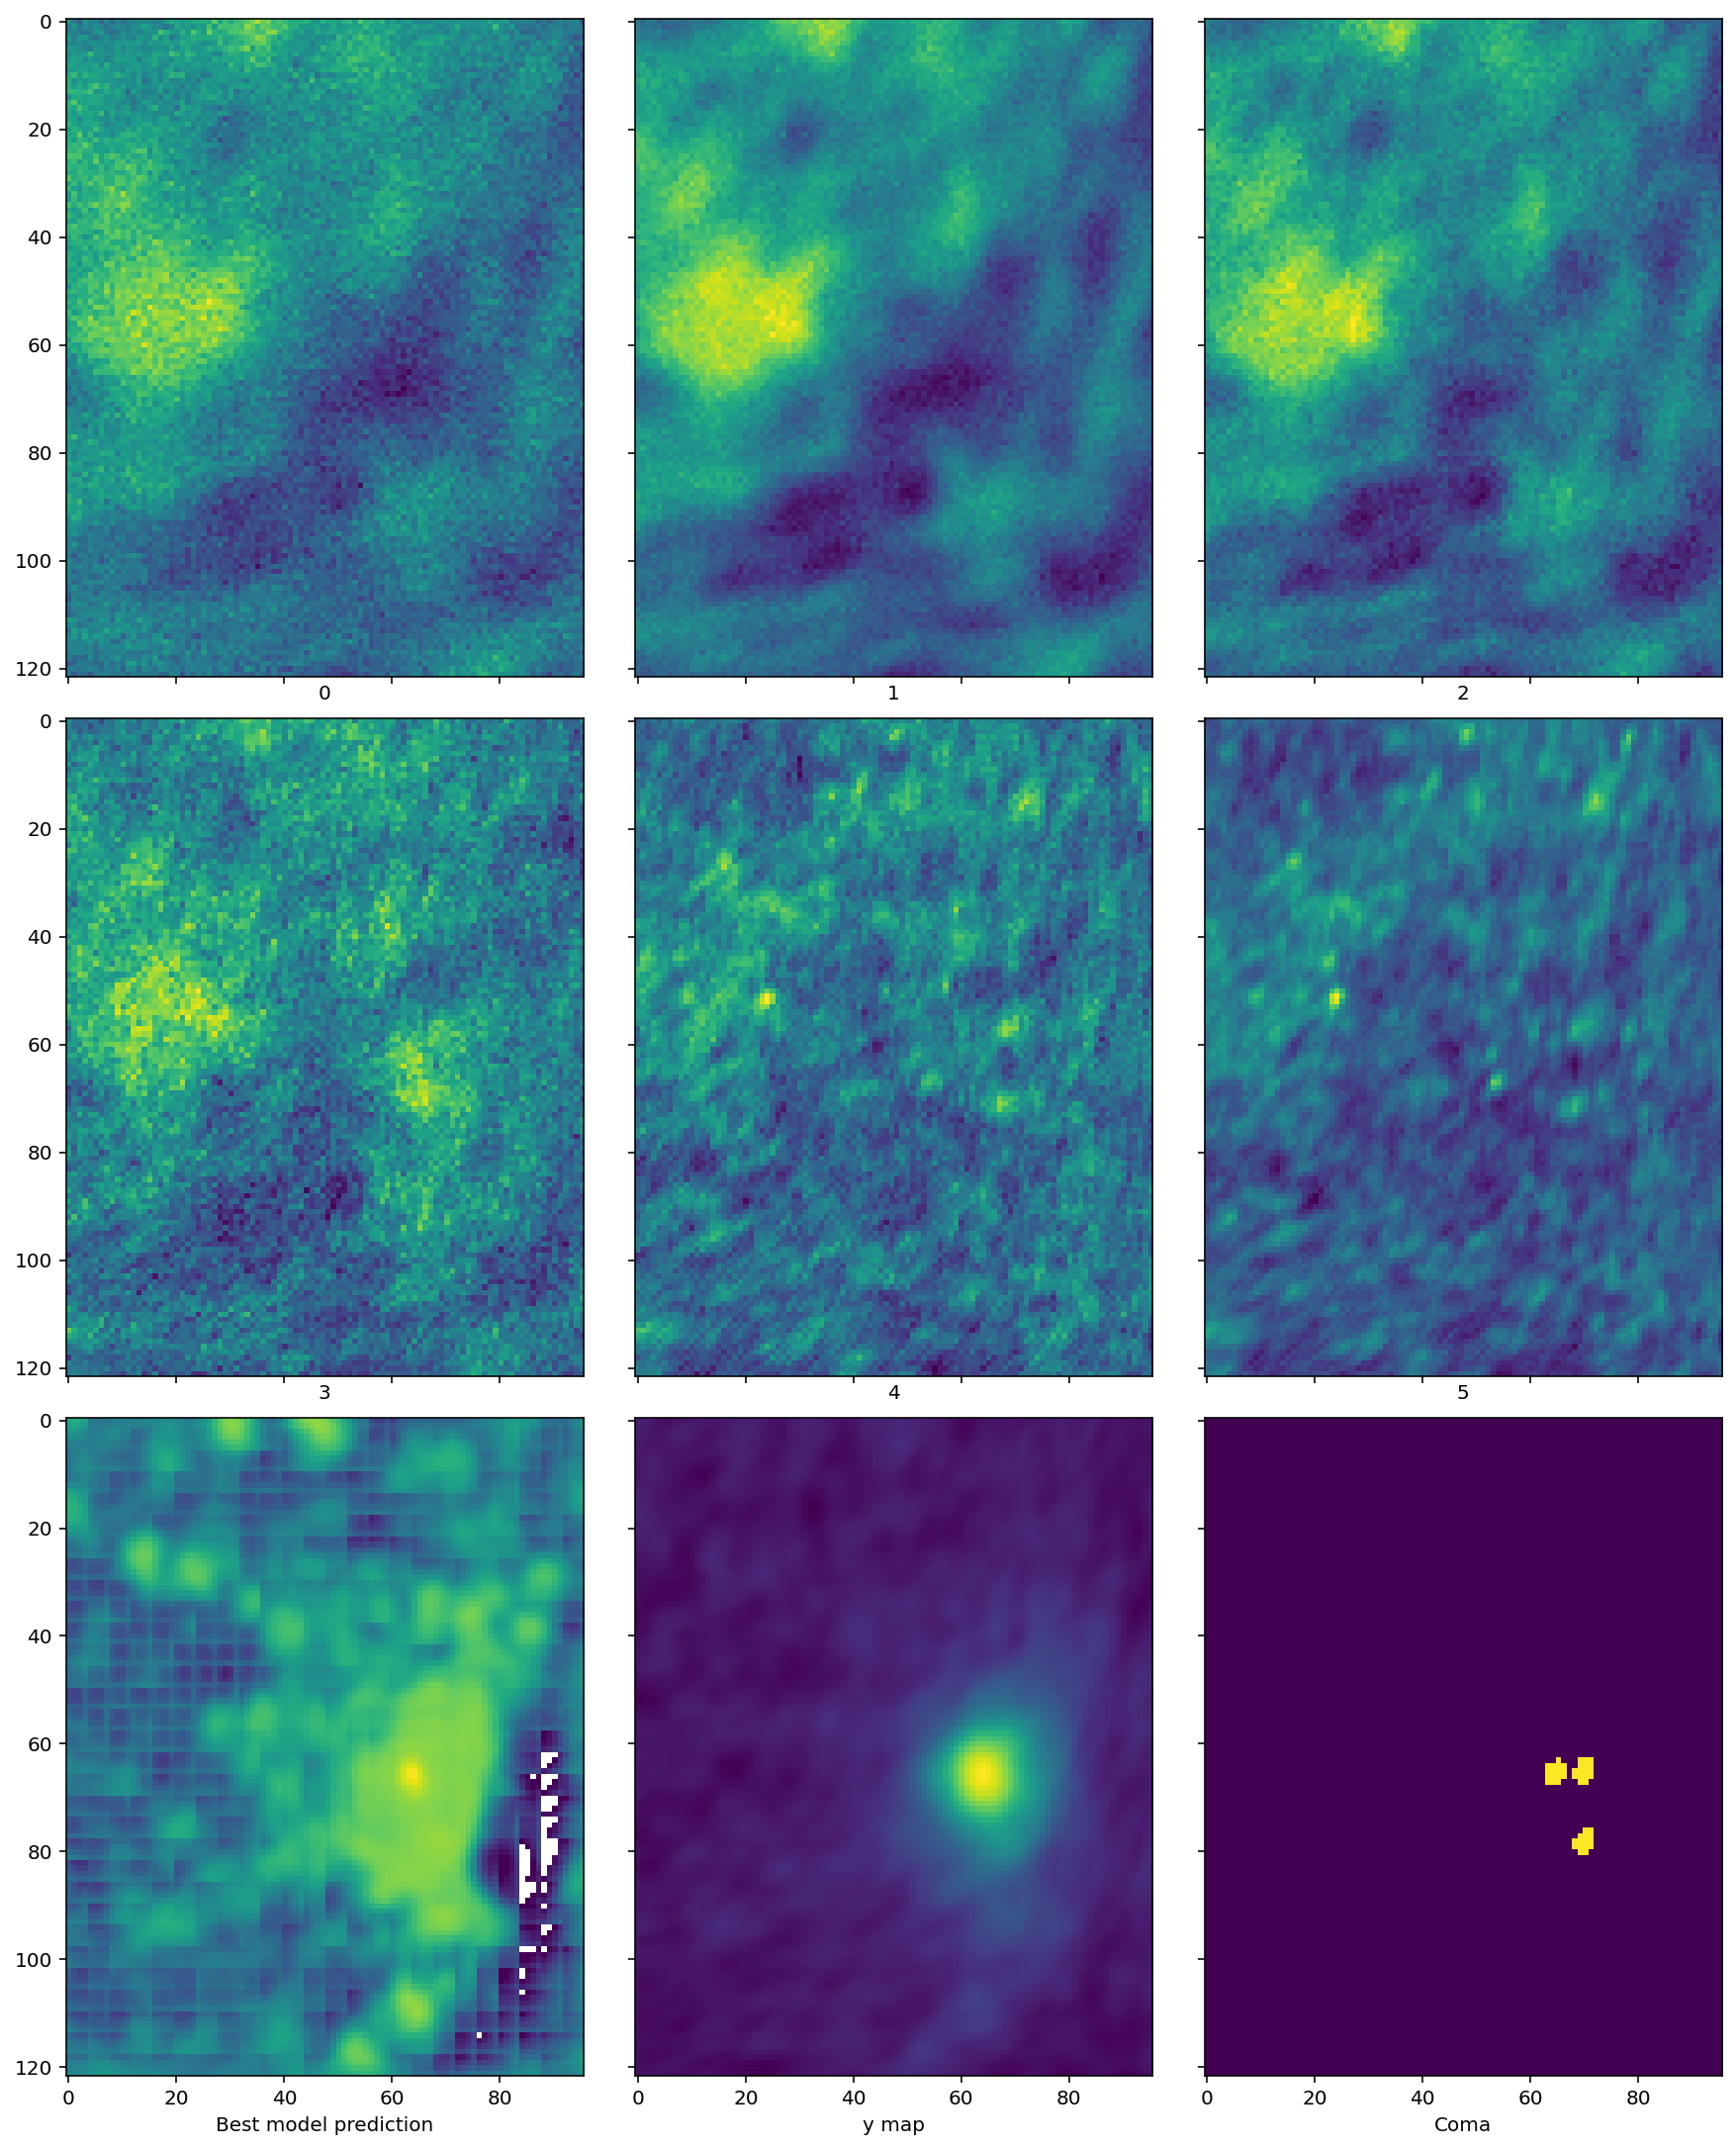

In [23]:
pic9(1, add_markers=False, size=64, picshape=np.array([5, 6.5]))

RA        44.2583
DEC       13.0049
name    A399-A401
pix2           37
pix      39244338
Name: 2, dtype: object


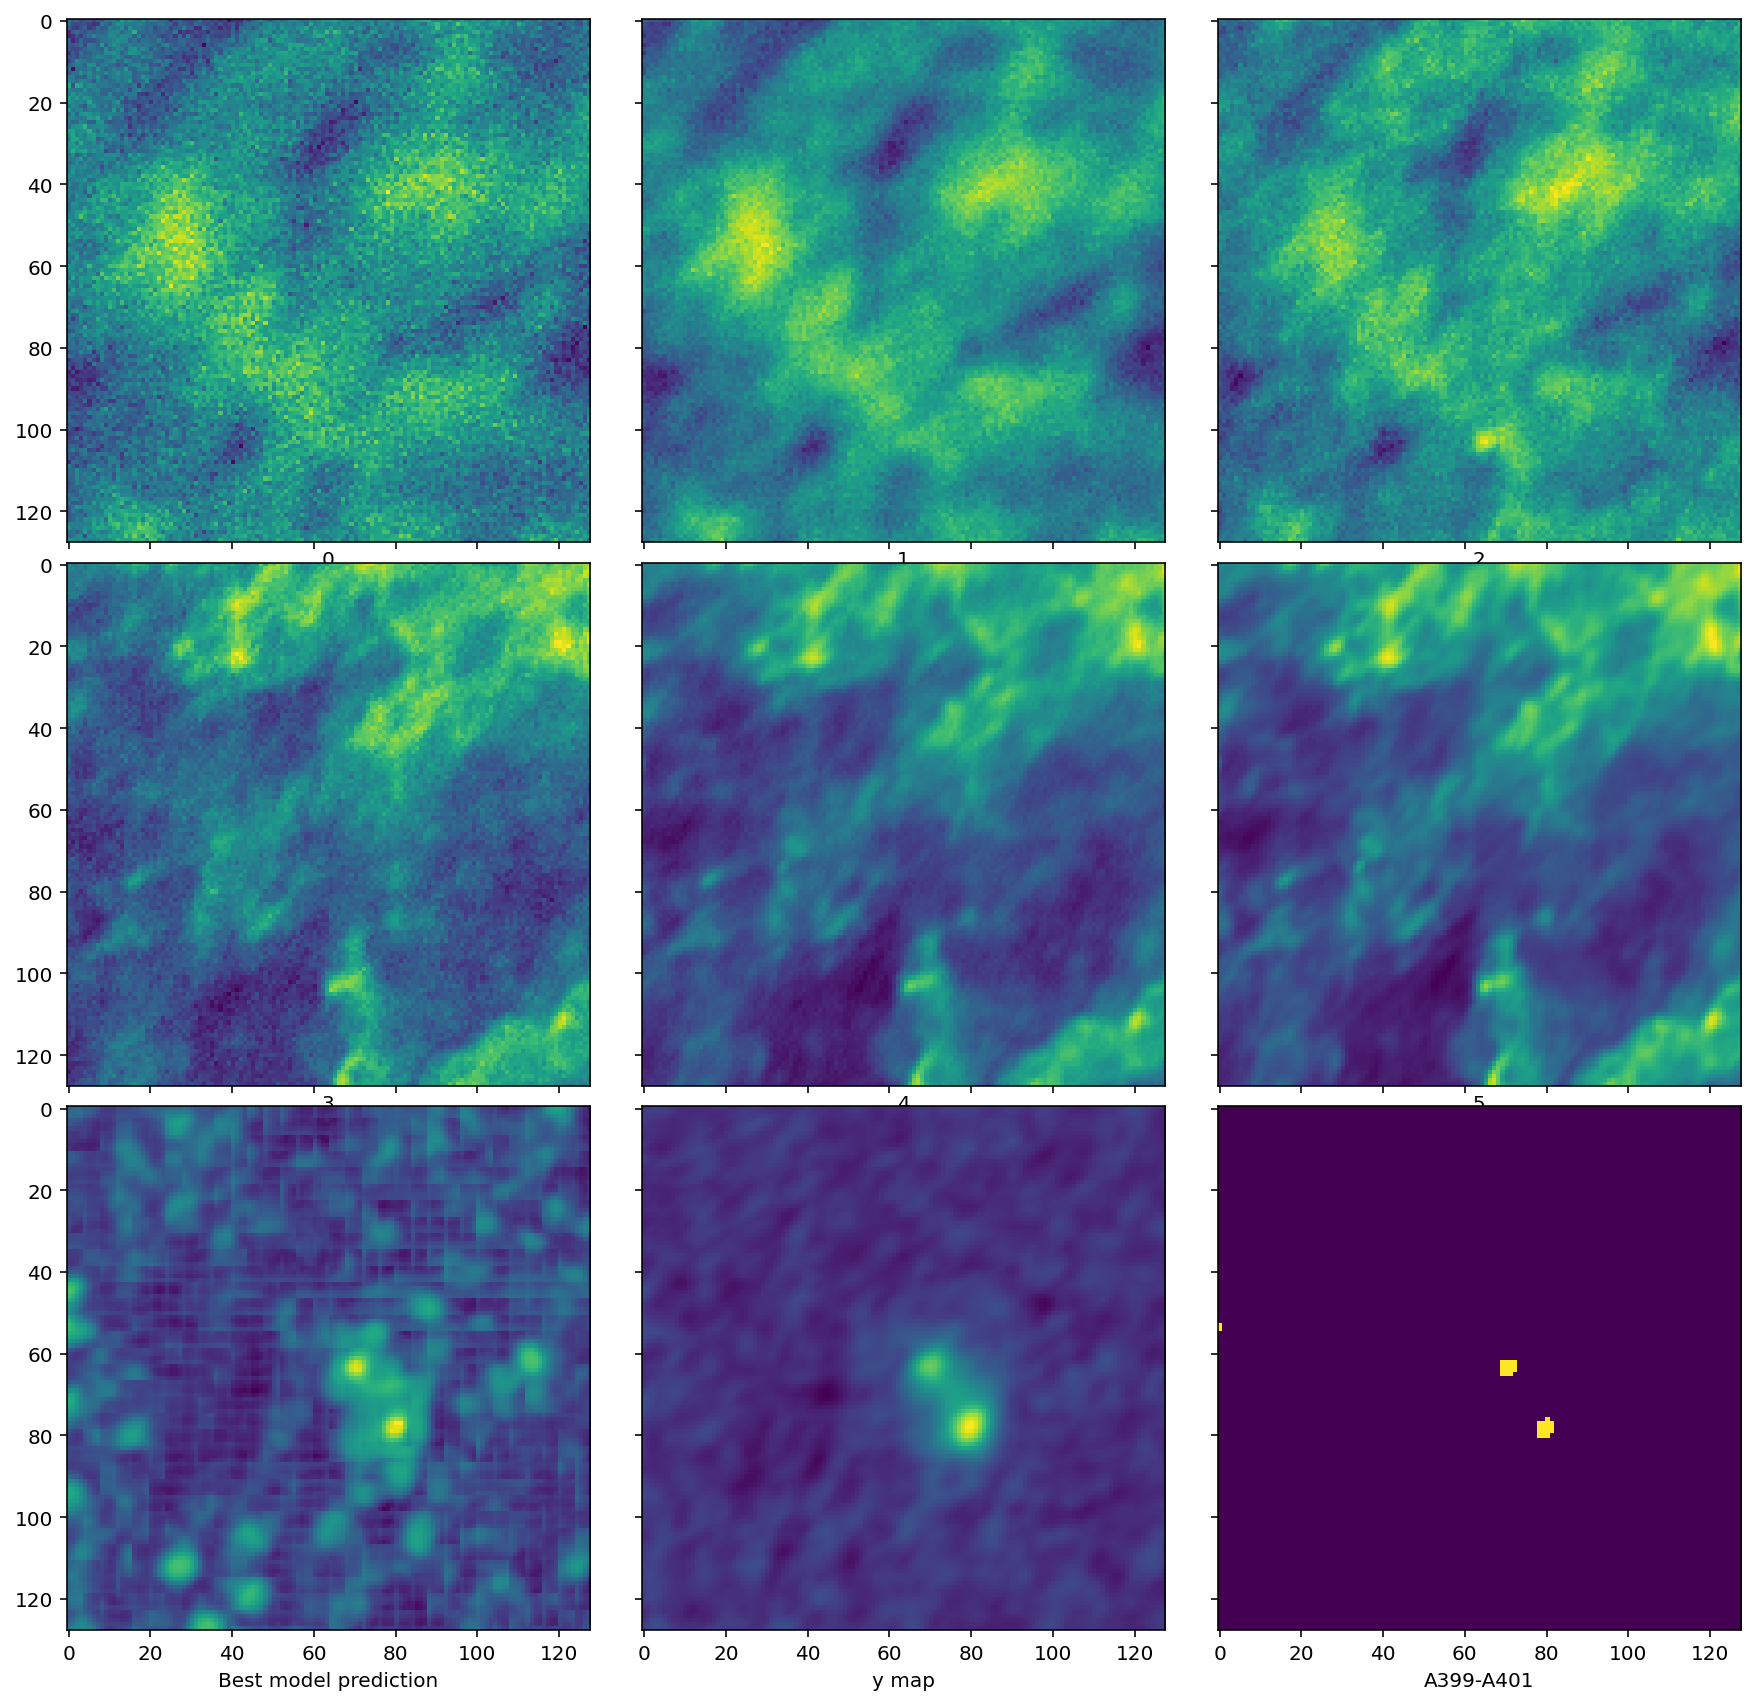

In [29]:
pic9(2, add_markers=False, size=64)

RA       201.979
DEC     -31.2333
name     Shapley
pix2          12
pix     13529997
Name: 3, dtype: object


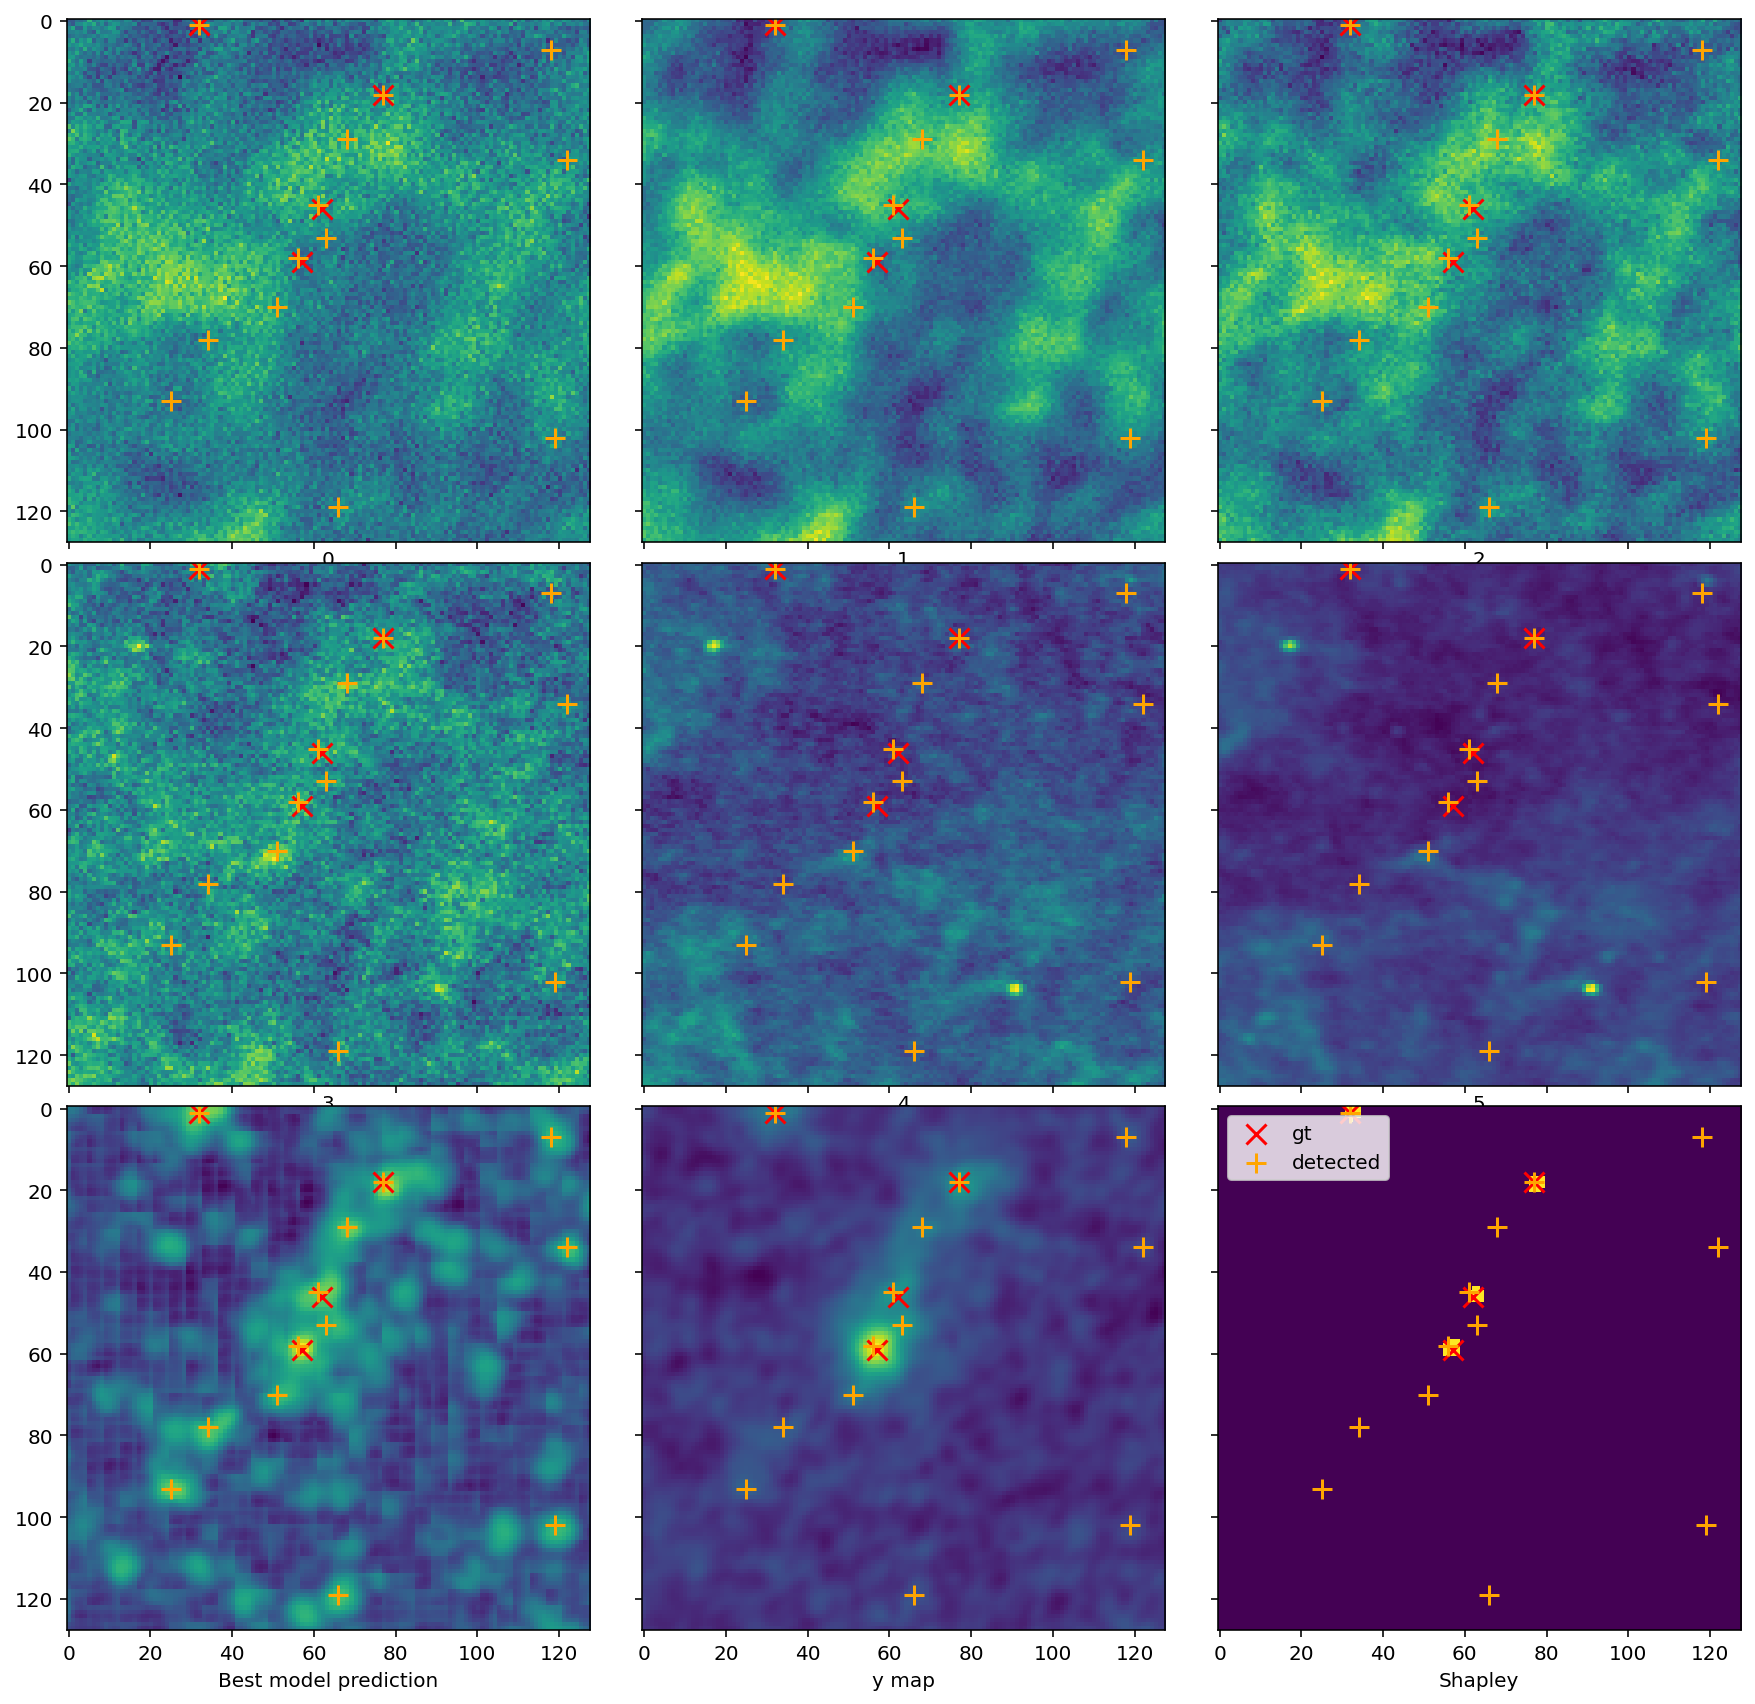

In [24]:
pic9(3, 64, add_markers=True)

RA          150.507
DEC         2.31204
name    G237.0+42.5
pix2              9
pix        10158405
Name: 4, dtype: object


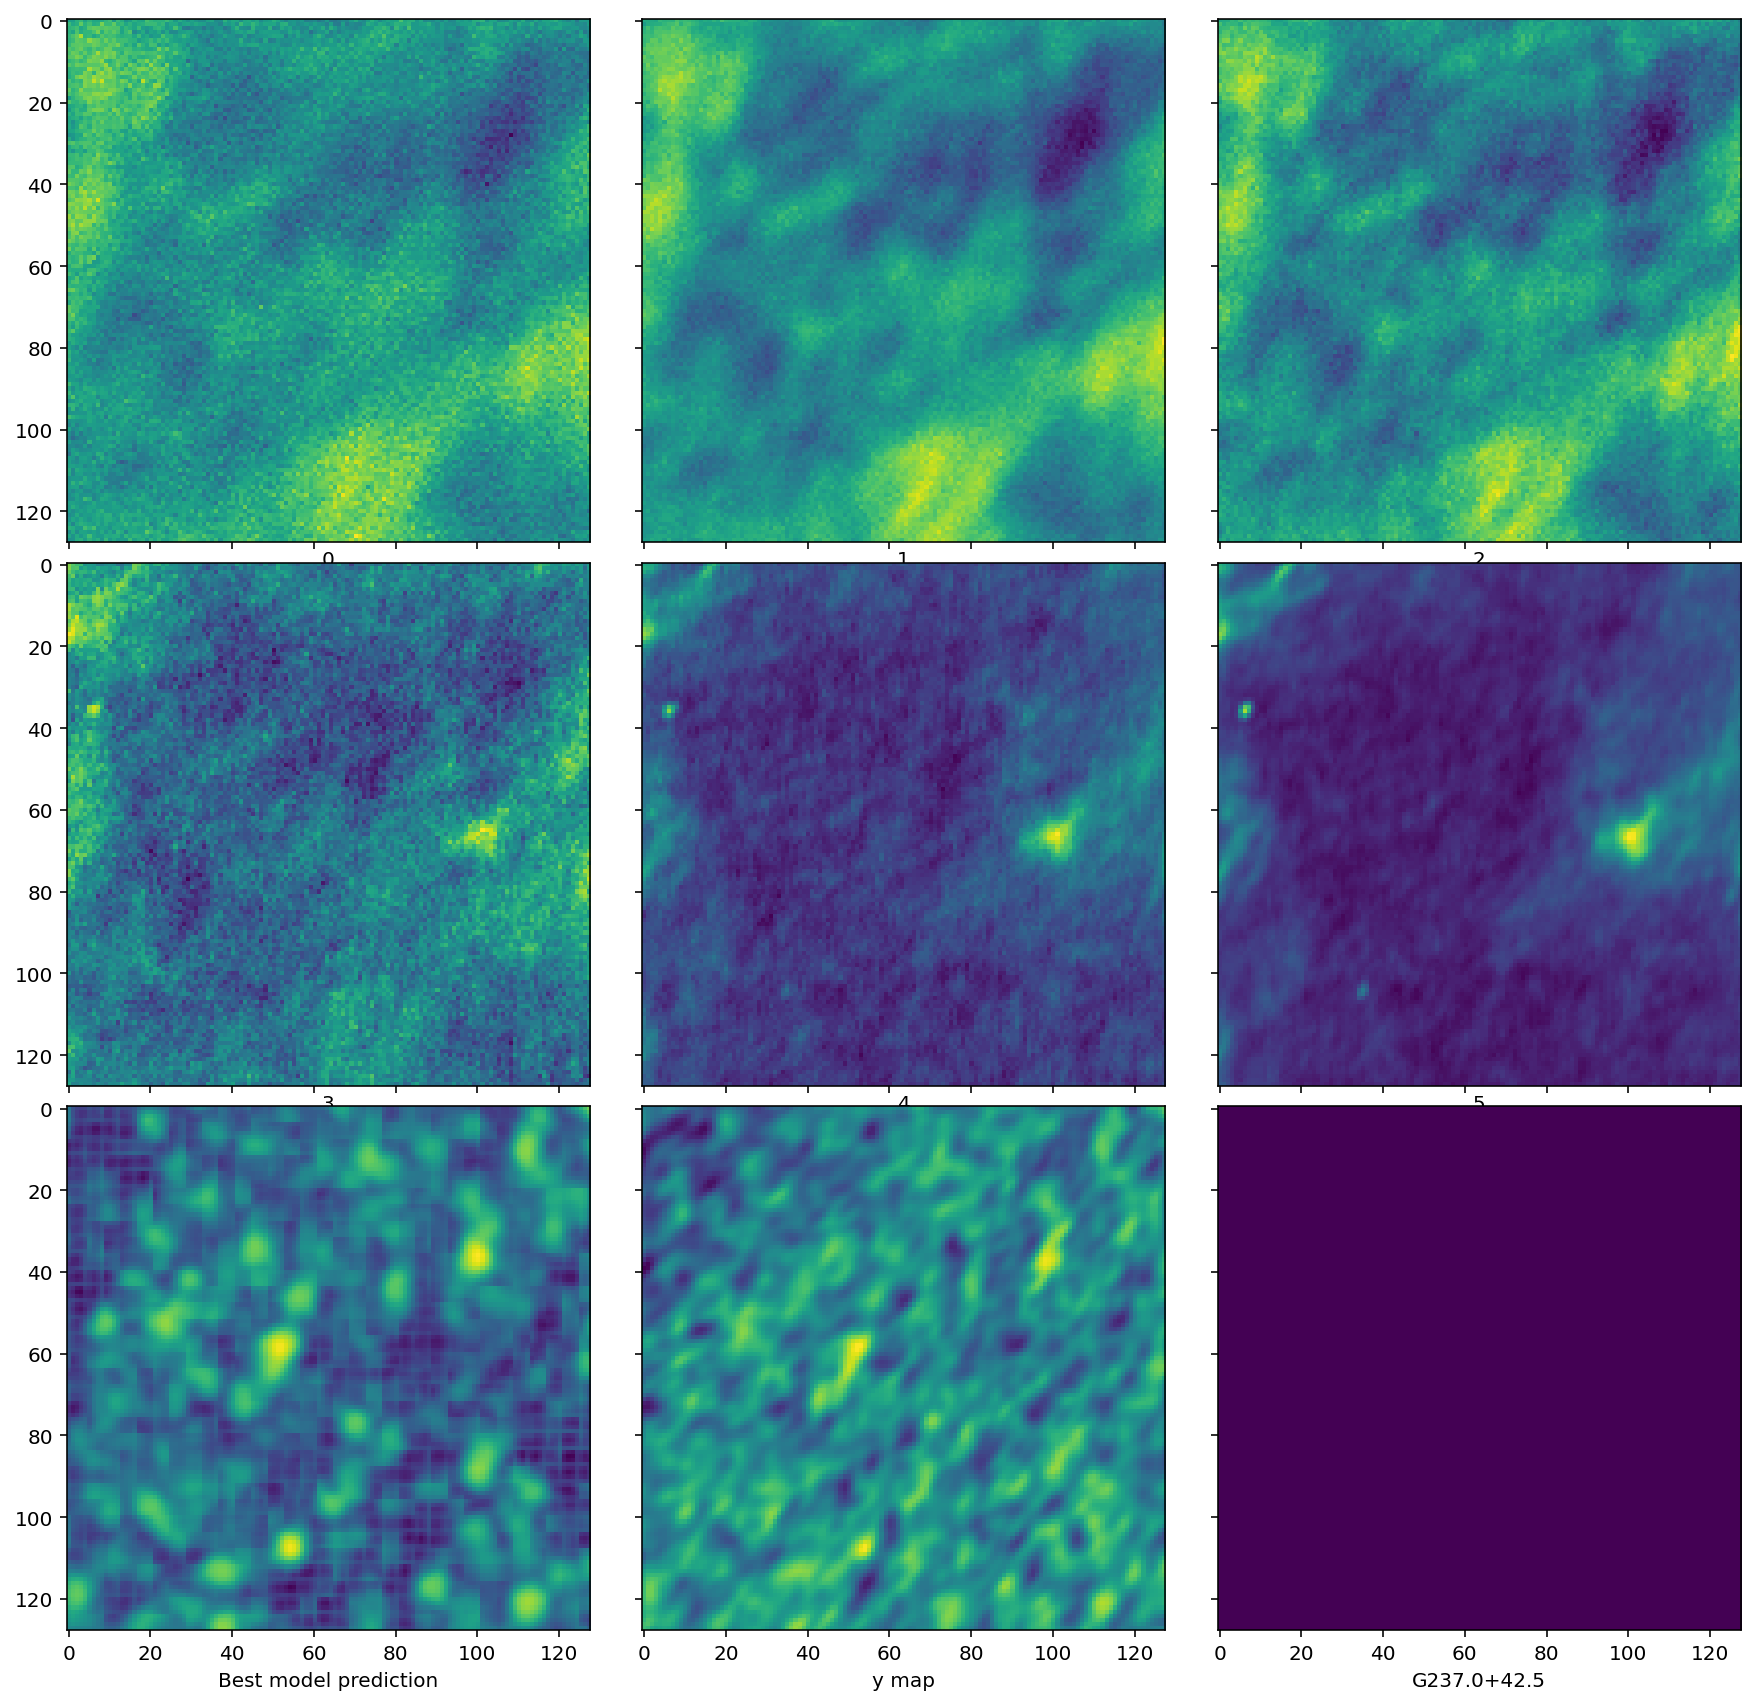

In [9]:
pic9(4, 64, add_markers=False)